In [1]:
# %matplotlib nbagg
%matplotlib inline

import warnings
import inspect
import matplotlib.pyplot as plt
import IPython.display
import numpy as np
from typing import Tuple
from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.laplacian_pyramid import bpp, quantise, rowdec, rowdec2, rowint, rowint2
from cued_sf2_lab.rl631_laplacian import plotImg
from cued_sf2_lab.dwt import dwt, idwt
from cued_sf2_lab.lbt import pot_ii
from cued_sf2_lab.dct import dct_ii, dct_iv, colxfm, regroup
from scipy.optimize import fsolve, Bounds, fminbound
dest = "D:\Cambridge\Part IIA\Projects\SF2 Image Processing\SF2-Image-Processing\Reports\Report 3 Figures\\"

# 10. Selection of preferred energy compaction options

The remainder of this project will concentrate on developing the rest of
an image compression system, based on a few of the filtering /
transformation schemes studied so far.

Since the subsequent processes are non-linear, we cannot expect to be able to
choose precisely the right front-end at this stage, so we adopt the pragmatic
approach of picking about three good candidates and trust that one of these
will lead to a near-optimum solution in the end. Remember that up to this point we have only been using entropy to give us an _estimate_ of the number of bits required, the accuracy of which is affected by subsequent stages.

At this stage it is worth trying your schemes with all three
test images, (`Lighthouse`, `Bridge`, and `Flamingo`). You will find `Bridge` more difficult to compress than the other two. You may also want to introduce other images of your own.

In [2]:
lighthouse, _ = load_mat_img(img='lighthouse.mat', img_info='X')
bridge, _ = load_mat_img(img='bridge.mat', img_info='X')
flamingo, _ = load_mat_img(img='flamingo.mat', img_info='X')

lighthouse = lighthouse - 128.0
bridge = bridge - 128.0
flamingo = flamingo - 128.0

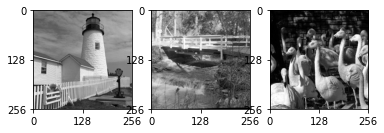

In [3]:
fig, axs = plt.subplots(1, 3)
plot_image(lighthouse, ax=axs[0])
plot_image(bridge, ax=axs[1])
plot_image(flamingo, ax=axs[2])

Write `.py` files to implement each of your
chosen schemes, so that you do not have to remember long sequences
of commands each time you run them. You can easily edit the M-files to introduce different options
later.  Using plenty of comments in these files will help when you want to change them.

# 11. Centre-clipped linear quantisers

The quantisers that you have used so far have all been uniform quantisers
(i.e.  all steps have been the same size).  However the probability
distributions of the intensities of the bandpass sub-images from the energy
compaction front-ends are usually highly peaked at zero.  The amount of data
compression depends heavily on the proportion of data samples which are
quantised to zero; if this approaches unity then high compression is
achieved.

Hence it is often found desirable to make the quantiser non-linear
so that more samples tend to be quantised to zero.  A simple way
to achieve this is to widen the step-size of the "zero" step.  In
a uniform quantiser, the "zero" step is normally centred on zero,
with rises to the next level at $\pm$ half of the step-size on
each side of zero. `quantise` allows a third argument `rise1` to be specified, which is
the point at which the first rise occurs on each side of the zero step.  A
value of `rise1` = `step/2` is the default, but `rise1` = $\left\{0.5, 1, 1.5\right\}\times$ `step` are worth investigating. To show what effect these have, try:

```python
x = np.arange(-100, 100+1)
y = quantise(x, 20, rise1)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()
```

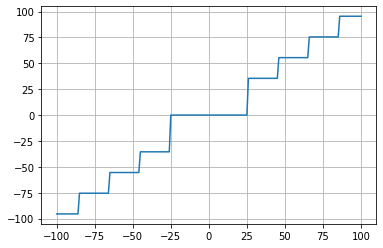

In [4]:
# your code here
step = 17
rise1 = step*3/2
x = np.arange(-100, 100+1)
y = quantise(x, 20, rise1)
fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()

A wider zero step means that more samples will be coded as zero and so the
entropy of the data will be reduced.  The use of a wide zero step is
beneficial if it results in a better entropy vs. error tradeoff than a uniform
quantiser.

<div class="alert alert-block alert-danger">

For each of your preferred front-end
schemes, investigate the effects of varying the first rise of the
quantiser.  To do this, you could plot how the quantising error
varies as a function of the number of bits for a few different ratios of
`rise1` to step-size, and hence find the ratio which gives the
best compression for a given rms error. </div>

### DCT8(16) centre clip

In [4]:
# Copied from notebook 7
def dctbpp(Yr, N):
    # Your code here
    total_bits = np.zeros((N,N))
    Yr_rows, Yr_cols = Yr.shape
    height = int(Yr_rows/N)
    width = int(Yr_cols/N)
    bits = width*height
    for i in range (N):
        for j in range (N):
            Ys = Yr[i*height:(i+1)*height, j*width:(j+1)*width]
            entropy = bpp(Ys)
            total_bits[i][j] = entropy*bits
            
    return np.sum(total_bits)

In [5]:
# Copied from notebook 7 and modified quantise() line to include rise1 parameter, removed line to solve for same rms.
def dct_n(img, n, rise1, N = 16, fixedN = False, step = 17):
    img_q = quantise(img, 17)
    rms_ref = np.std(img_q-img)
    tbit_imgq = bpp(img_q)*img.shape[0]*img.shape[1]
    
    Cn = dct_ii(n)
    
    Yn = colxfm(colxfm(img, Cn).T, Cn).T
    Ynq = quantise(Yn, step, rise1)
    
    Ynr = regroup(Ynq, n)/n
    Zn = colxfm(colxfm(Ynq.T, Cn.T).T, Cn.T)
    rms_Z = np.std(Zn-img)
    if fixedN:
        tbit_dctn = dctbpp(Ynr, N)
    else:
        tbit_dctn = dctbpp(Ynr, n)
    
    comp_ratio_n = tbit_imgq/tbit_dctn
    
    return [tbit_dctn, comp_ratio_n, rms_Z, Zn]

In [8]:
# calculate RMS error and tbit for a range of step sizes, for various values of ratio
steps_DCT = np.arange(10, 50, 0.2)
ratios_DCT = np.array([0.4, 0.6, 0.8, 1.0, 1.2])
n_DCT = 8 # DCT optimal = 8
tbit_DCT = []
rms_DCT = []
for ratio in ratios_DCT:
    dct_tbits = []
    dct_rms = []
    for step in steps_DCT:
        # fixedN = True: image split into 16x16 sub-images to be compressed
        dct_08 = dct_n(lighthouse, n_DCT, ratio*step, step=step, fixedN = False)
        dct_tbits.append(dct_08[0])
        dct_rms.append(dct_08[2])
    tbit_DCT.append(dct_tbits)
    rms_DCT.append(dct_rms)

In [9]:
# get compression ratio for dct8 rise = 1
# convert step to index in steps list
step = 23.691
index = round((step-10)*5)

img = lighthouse
dct08_tbit = tbit_DCT[3][index]
tbit_ref = bpp(quantise(img, 17))*img.shape[0]*img.shape[1]
print("ref total bits:", tbit_ref)
print("total bits:", dct08_tbit)
print("comp ratio: ", tbit_ref/dct08_tbit)

ref total bits: 228119.03651868744
total bits: 49460.92269788422
comp ratio:  4.612106367527302


In [21]:
n = 8
step = 17
ratio = 1

print(dct_n(lighthouse, n, ratio*step, step=step, fixedN = False)[0:3])
print(dct_n(lighthouse, n, ratio*step, step=step, fixedN = True)[0:3])

[66530.77996036573, 3.428774420720521, 5.268842305516852]
[60627.02110790054, 3.762662792102124, 5.268842305516852]


In [23]:
n = 8
step = 17
ratio = 1

print(dct_n(bridge, n, ratio*step, step=step, fixedN = False)[0:3])
print(dct_n(bridge, n, ratio*step, step=step, fixedN = True)[0:3])

[88980.1254059175, 2.664085493785431, 7.032970904756508]
[85504.6700263909, 2.772370927294941, 7.032970904756508]


In [22]:
n = 8
step = 17
ratio = 1

print(dct_n(flamingo, n, ratio*step, step=step, fixedN = False)[0:3])
print(dct_n(flamingo, n, ratio*step, step=step, fixedN = True)[0:3])

[85324.64775447798, 2.773643400820122, 6.12532867836342]
[82453.6472575784, 2.8702204698380713, 6.12532867836342]


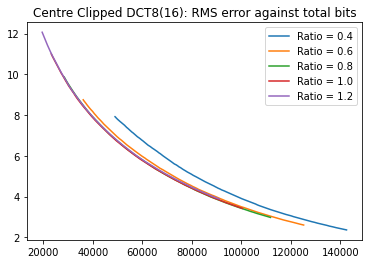

In [11]:
# Plot rms against tbit for various values of ratio
fig, ax = plt.subplots()
for i in range (len(ratios_DCT)):
    plt.plot(tbit_DCT[i], rms_DCT[i], label = 'Ratio = '+ str(ratios_DCT[i]))

# plt.xlim((40000, 90000))
# plt.ylim((4,7.5))
plt.title("Centre Clipped DCT8(16): RMS error against total bits")
plt.legend()
plt.savefig(dest+'centre clipped DCT8(16).png')
plt.show()

### LBT8(16) centre clip

In [6]:
# copied from notebook 8, did not change anything
def forwardLBT(img, N, s):
    # Generate filters
    Pf, Pr = pot_ii(N, s)
    
    # Pre-filtering
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    img_p = img.copy()  # copy the non-transformed edges directly from X
    img_p[t,:] = colxfm(img_p[t,:], Pf)
    img_p[:,t] = colxfm(img_p[:,t].T, Pf).T
    
    # DCT
    Cn = dct_ii(N)
    Yn = colxfm(colxfm(img_p, Cn).T, Cn).T
    
    return Yn
        
    
def reverseLBT(img, N, s):
    # Generate filters
    Pf, Pr = pot_ii(N, s)
    
    # Inverse DCT
    Cn = dct_ii(N)
    Zn = colxfm(colxfm(img.T, Cn.T).T, Cn.T)
    
    # Post-filtering
    t = np.s_[N//2:-N//2]  # N is the DCT size, I is the image size
    Zp = Zn.copy()  #copy the non-transformed edges directly from Z
    Zp[:,t] = colxfm(Zp[:,t].T, Pr.T).T
    Zp[t,:] = colxfm(Zp[t,:], Pr.T)
    
    return Zp

In [7]:
# copied from notebook 8, modified to add in rise1 parameter and removed line to solve for same rms
def lbt_n(img, N, rise1, step=17, s=1.4, fixedN = False):
    img_q = quantise(img, 17)
    tbit_imgq = bpp(img_q)*img.shape[0]*img.shape[1]
    
    fLBT = forwardLBT(img, N, s)
    fLBTq = quantise(fLBT, step, rise1)
    fLBTr = regroup(fLBTq, N)/N
    rLBT = reverseLBT(fLBTq, N, s)
    rms_LBT = np.std(rLBT-img)
    
    if fixedN:
        tbit_lbt = dctbpp(fLBTr, 16)
    else:
        tbit_lbt = dctbpp(fLBTr, N)
        
    comp_ratio = tbit_imgq/tbit_lbt
    
    return [tbit_lbt, comp_ratio, rms_LBT, rLBT, fLBTq, fLBTr, fLBT]

In [8]:
# Check values against report 2 to ensure modified function works as intended
n = 4
step = 28.755
print(lbt_n(lighthouse, n, 0.5*step, step, 1.4, False)[0:3])
print(lbt_n(lighthouse, n, 0.5*step, step, 1.4, True)[0:3])
print(lbt_n(lighthouse, n, 1*step, step, 1.4, False)[0:3])
print(lbt_n(lighthouse, n, 1*step, step, 1.4, True)[0:3])

[77842.0322429867, 2.930538038968532, 4.861104902743911]
[64010.67146117374, 3.563765717674984, 4.861104902743911]
[53404.00464349007, 4.271571730276506, 6.584188531625546]
[43005.599191392255, 5.304403166282273, 6.584188531625546]


In [24]:
# s = 1.4
step = 18.89638031
print(lbt_n(lighthouse, 4, 1*step, step, 1.4, False)[0:3])
print(lbt_n(lighthouse, 4, 1*step, step, 1.4, True)[0:3])

[73929.32034424035, 3.085636868518292, 4.86109385213534]
[61008.006884099064, 3.7391655320269717, 4.86109385213534]
[77709.66722359488, 2.9355297052336877, 4.645745118042853]
[64451.75948542359, 3.5393764008921873, 4.645745118042853]


In [27]:
# s = golden
step = 20.10827212
print(lbt_n(lighthouse, 4, 1*step, step, (1 + (5**0.5)) / 2, False)[0:3])
print(lbt_n(lighthouse, 4, 1*step, step, (1 + (5**0.5)) / 2, True)[0:3])

[74282.43981190321, 3.070968550525895, 4.861252976298097]
[61427.83357450084, 3.7136103170889196, 4.861252976298097]


In [26]:
# s = 1.4
step = 13.5847989
print(lbt_n(bridge, 4, 1*step, step, 1.4, False)[0:3])
print(lbt_n(bridge, 4, 1*step, step, 1.4, True)[0:3])

[126289.95893001444, 1.8770349071099042, 4.92222962227058]
[117265.45251755658, 2.021487626917424, 4.92222962227058]
[134311.29688521684, 1.7649346467981621, 4.696016080816713]
[125125.4965075333, 1.894503262289484, 4.696016080816713]


In [28]:
# s = golden
step = 14.27919878
print(lbt_n(bridge, 4, 1*step, step, (1 + (5**0.5)) / 2, False)[0:3])
print(lbt_n(bridge, 4, 1*step, step, (1 + (5**0.5)) / 2, True)[0:3])

[129237.22484880436, 1.834228966201036, 4.9222582149800065]
[120336.19924972666, 1.9699031779886609, 4.9222582149800065]


In [33]:
# s = 1.4
step = 15.98387543
print(lbt_n(flamingo, 4, 1*step, step, 1.4, False)[0:3])
print(lbt_n(flamingo, 4, 1*step, step, 1.4, True)[0:3])

[99364.64890492054, 2.3817338337094434, 4.943992534172779]
[92080.47544604083, 2.570144702502021, 4.943992534172779]


In [35]:
# s = golden
step = 16.82981791
print(lbt_n(flamingo, 4, 1*step, step, (1 + (5**0.5)) / 2, False)[0:3])
print(lbt_n(flamingo, 4, 1*step, step, (1 + (5**0.5)) / 2, True)[0:3])

[100836.79861844443, 2.3469621151600193, 4.944072167150577]
[93596.7967021176, 2.5285068988494013, 4.944072167150577]


In [317]:
# calculate RMS error and tbit for a range of step sizes, for various values of ratio
steps_LBT = np.arange(10, 50, 0.2)
ratios_LBT = np.array([0.4, 0.6, 0.8, 1.0, 1.2])
n_LBT = 8 # LBT optimal = 8
tbit_LBT = []
rms_LBT = []
for ratio in ratios_LBT:
    lbt_tbits = []
    lbt_rms = []
    for step in steps_LBT:
        # fixedN = True: image split into 16x16 sub-images to be compressed
        lbt_08 = lbt_n(lighthouse, n_LBT, ratio*step, step=step, s=1.4, fixedN = True)
        lbt_tbits.append(lbt_08[0])
        lbt_rms.append(lbt_08[2])
    tbit_LBT.append(lbt_tbits)
    rms_LBT.append(lbt_rms)

In [318]:
# check for ratio = 0.5, step = 25.885
step = 25.885
lbt_check = lbt_n(lighthouse, 8, 0.5*step, step=step, s=1.4, fixedN = True)
print(lbt_check[1])

3.4228310530085206


In [319]:
# ratio = 1, step = 25.885
step = 25.885
lbt_1 = lbt_n(lighthouse, 8, 1*step, step=step, s=1.4, fixedN = True)
print(lbt_1[1])

5.594594632427461


<IPython.core.display.Javascript object>


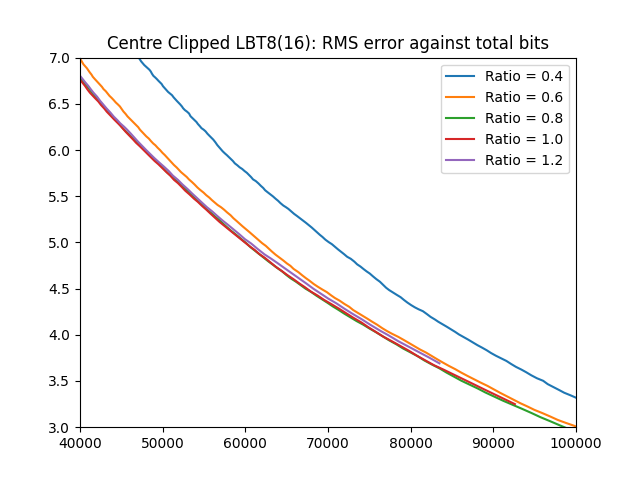

In [238]:
# Plot rms against tbit for various values of ratio
fig, ax = plt.subplots()
for i in range (len(ratios_LBT)):
    plt.plot(tbit_LBT[i], rms_LBT[i], label = 'Ratio = '+ str(ratios_LBT[i]))

plt.xlim((40000, 100000))
plt.ylim((3,7))
plt.title("Centre Clipped LBT8(16): RMS error against total bits")
plt.legend()
plt.savefig(dest+'centre clipped LBT8(16).png')
plt.show()

### DWT functions copied from notebook 9

In [155]:
# copied from notebook 9 with no changes
def multidwt(img, N):
    # Define filter
    h1 = np.array([-1, 2, 6, 2, -1])/8
    h2 = np.array([-1, 2, -1])/4

    rows, cols = img.shape
    if rows % 2 or cols % 2:
        raise ValueError("Image dimensions must be even")
        
    if N == 0:
        return img
    else:
        Y = dwt(img)
        for i in range(1, N):
            rows = rows//2
            Y[:rows, :rows] = dwt(Y[:rows, :rows])

        return Y
    
def multiidwt(img, N):
    # Define inverse filters
    g1 = np.array([1, 2, 1])/2
    g2 = np.array([-1, -2, 6, -2, -1])/4
    
    rows, cols = img.shape
    if rows % 2 or cols % 2:
        raise ValueError("Image dimensions must be even")

    for i in range(N, 0, -1):
        img[:rows//2**(i-1), :cols//2**(i-1)] = idwt(img[:rows//2**(i-1), :cols//2**(i-1)], g1, g2)
        
    return img

In [199]:
# copied from notebook 9 and modified function to accept rise1 parameter for quantisation step
def quantdwt(Y: np.ndarray, dwtstep: np.ndarray, ratio: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Parameters:
        Y: the output of `dwt(X, n)`
        dwtstep: an array of shape `(3, n+1)`
        rise1: width of center clipping of quantisation
    Returns:
        Yq: the quantized version of `Y`
        dwtenc: an array of shape `(3, n+1)` containing the entropies
    """
    # your code here
    n = dwtstep.shape[1]-1
    rows, cols = Y.shape
    Yq = np.zeros(Y.shape)
    dwtent = np.zeros(dwtstep.shape)
    
    for i in range (0, n):
        Yq[:rows//2**(i+1), cols//2**(i+1):cols//2**i] = quantise(Y[:rows//2**(i+1), cols//2**(i+1):cols//2**i], dwtstep[0, i], ratio*dwtstep[0, i])
        Yq[rows//2**(i+1):rows//2**i, :cols//2**(i+1)] = quantise(Y[rows//2**(i+1):rows//2**i, :cols//2**(i+1)], dwtstep[1, i], ratio*dwtstep[1, i])
        Yq[rows//2**(i+1):rows//2**i, cols//2**(i+1):cols//2**i] = quantise(Y[rows//2**(i+1):rows//2**i, cols//2**(i+1):cols//2**i], dwtstep[2, i], ratio*dwtstep[2, i])
        
        dwtent[0, i] = bpp(Yq[:rows//2**(i+1), cols//2**(i+1):cols//2**i])
        dwtent[1, i] = bpp(Yq[rows//2**(i+1):rows//2**i, :cols//2**(i+1)])
        dwtent[2, i] = bpp(Yq[rows//2**(i+1):rows//2**i, cols//2**(i+1):cols//2**i])
        
    Yq[:rows//2**n, :cols//2**n] = quantise(Y[:rows//2**n, :cols//2**n], dwtstep[0,n], ratio*dwtstep[0, n])
    dwtent[0, n] = bpp(Yq[:rows//2**n, :cols//2**n])
    
    return Yq, dwtent

In [200]:
# copied from notebook 9 with no changes
# Impulse response calculation for equal MSE step size
n = 256
imp = np.zeros((4,8))

for i in range (1, 9):
    q1 = int(256//2**(i-1)*1/4)
    q3 = int(256//2**(i-1)*3/4)
    
    empty = np.zeros((n, n))
    empty[q1, q3] = 100
    imp[0][i-1] = np.sum(multiidwt(empty, i)**2)
    
    empty = np.zeros((n, n))
    empty[q3, q1] = 100
    imp[1][i-1] = np.sum(multiidwt(empty, i)**2)
    
    empty = np.zeros((n, n))
    empty[q3, q3] = 100
    imp[2][i-1] = np.sum(multiidwt(empty, i)**2)
    
    empty = np.zeros((n, n))
    empty[q1, q1] = 100
    imp[3][i-1] = np.sum(multiidwt(empty, i)**2)
    
ssratio = 1/np.sqrt(imp)

dwtsteps = [np.array([[1], [0], [0]])]
for i in range (1, 9):
    dwtstep = np.zeros((3, i+1))
    dwtstep[:, :i] = ssratio[:3, :i]
    dwtstep[0, i] = ssratio[3, i-1]
    dwtsteps += [dwtstep/dwtstep[0,0]]
    
# for i in dwtsteps:
#     print(np.round(i, 3))

In [201]:
# copied from notebook 9, did not modify code, just converted to a function
# tbit calculation for DWT
def get_tbit(dwtent, img):
    tbit = 0
    rows, cols = img.shape
    n = dwtent.shape[1]-1
    for j in range(0, n):
        tbit += (1/4)**(j+1)*rows*cols*(dwtent[0][j]+dwtent[1][j]+dwtent[2][j])
    tbit += (1/4)**(n)*rows*cols*dwtent[0][n]
    
    return tbit

### DWT5 equal step centre clip

In [239]:
# calculate rms error and tbit for a range of ratios for rise1/step
steps_DWT = np.arange(10, 50, 0.1)
ratios_DWT = np.array([0.4, 0.6, 0.8, 1.0, 1.2])
n_DWT = 5 # optimal for MSE DWT
tbit_DWT = []
rms_DWT = []

for ratio in ratios_DWT:
    dwt_tbits = []
    dwt_rms = []
    for step in steps_DWT:
        dwtstep = np.ones((3, n_DWT+1))*step
        Y_dwt = multidwt(lighthouse, n_DWT)
        Yq, dwtent = quantdwt(Y_dwt, dwtstep, ratio)
        Z = multiidwt(Yq, n_DWT)
        dwt_tbits.append(get_tbit(dwtent, lighthouse))
        dwt_rms.append(np.std(Z-lighthouse))
    tbit_DWT.append(dwt_tbits)
    rms_DWT.append(dwt_rms)

<IPython.core.display.Javascript object>


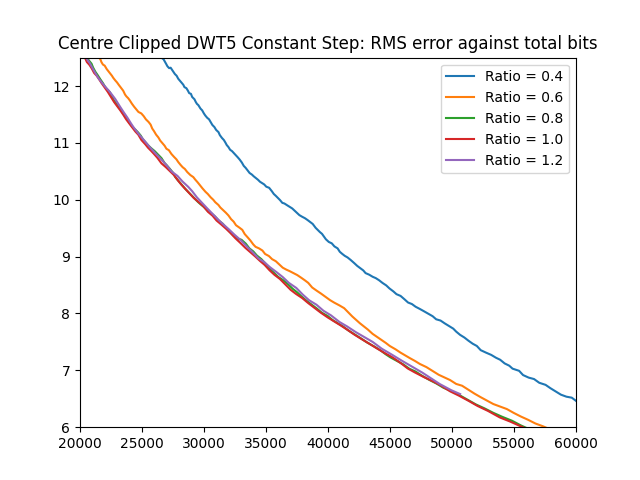

In [243]:
# Plot rms against tbit for various values of ratio
fig, ax = plt.subplots()
for i in range (len(ratios_DWT)):
    plt.plot(tbit_DWT[i], rms_DWT[i], label = 'Ratio = '+ str(ratios_DWT[i]))

plt.xlim((20000, 60000))
plt.ylim((6.,12.5))
plt.title("Centre Clipped DWT5 Constant Step: RMS error against total bits")
plt.legend()
plt.savefig(dest+'centre clipped DWT5 Constant Step.png')
plt.show()

### DWT5 Equal MSE centre clip

In [244]:
# calculate rms error and tbit for a range of ratios for rise1/step
steps_DWT = np.arange(10, 50, 0.2)
ratios_DWT = np.array([0.4, 0.6, 0.8, 1.0, 1.2])
n_DWT = 5 # optimal for MSE DWT
tbit_DWT = []
rms_DWT = []

for ratio in ratios_DWT:
    dwt_tbits = []
    dwt_rms = []
    for step in steps_DWT:
        Y_dwt = multidwt(lighthouse, n_DWT)
        Yq, dwtent = quantdwt(Y_dwt, dwtsteps[n_DWT]*step, ratio)
        Z = multiidwt(Yq, n_DWT)
        dwt_tbits.append(get_tbit(dwtent, lighthouse))
        dwt_rms.append(np.std(Z-lighthouse))
    tbit_DWT.append(dwt_tbits)
    rms_DWT.append(dwt_rms)

<IPython.core.display.Javascript object>


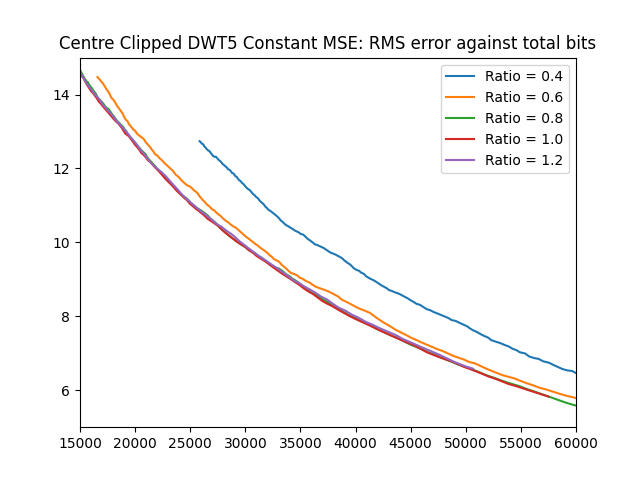

In [245]:
# Plot rms against tbit for various values of ratio
fig, ax = plt.subplots()
for i in range (len(ratios_DWT)):
    plt.plot(tbit_DWT[i], rms_DWT[i], label = 'Ratio = '+ str(ratios_DWT[i]))

plt.xlim((15000, 60000))
plt.ylim((5,15))
plt.title("Centre Clipped DWT5 Constant MSE: RMS error against total bits")
plt.legend()
plt.savefig(dest+'centre clipped DWT5 Constant MSE.png')
plt.show()

Most current image compression standards use quantisers with a
double-width centre step (`rise1 = step`). Do not spend too much time
on this as the compression gains are likely to be quite small.

<div class="alert alert-block alert-danger">


Discuss whether your results indicate that `rise1 = step`
is a reasonable compromise if all quantisers are to be similar.
</div>

A final strategy which you can consider is to completely suppress some
sub-images or DCT coefficients.  This is equivalent to increasing `rise1`
to a very large value for these components.  In the sub-images / coefficients
which represent only the highest horizontal and vertical frequency components
combined, the effects of suppression can be almost unnoticable and yet
a useful saving in number of bits can be achieved.

<div class="alert alert-block alert-danger">

Investigate any additional gains which can be achieved with suppression
of some sub-images / coefficients.
</div>

In [246]:
supp_rise1 = 100

### DCT suppress

In [420]:
def dct_n_supp(img, n, rise1, N = 16, fixedN = False, step = 17):
    img_q = quantise(img, 17)
    rms_ref = np.std(img_q-img)
    tbit_imgq = bpp(img_q)*img.shape[0]*img.shape[1]
    
    Cn = dct_ii(n)
    
    Yn = colxfm(colxfm(img, Cn).T, Cn).T
    
    # Regroup to quantise
    Ynr = regroup(Yn, n)/n
    Ynq = quantise(Ynr, step, rise1)
    Ynq[-256//n:, -256//n:] = quantise(Ynr[-256//n:, -256//n:], step, 100)

    Ynq_nosupp = quantise(Yn, step, rise1)
    Ynr_nosupp = regroup(Ynq_nosupp, n)/n
    
    plotImg([Ynq, Ynr_nosupp], cols=2)
    # Undo regroup before inverse transforming
    Znr = regroup(Ynq, 256//n)/(256//n)
    Zn = colxfm(colxfm(Znr.T, Cn.T).T, Cn.T)
    Zn_nosupp = colxfm(colxfm(Ynq_nosupp.T, Cn.T).T, Cn.T)
    
    plotImg([Znr, Zn, Zn_nosupp], cols=3)
    
    
    rms_Z = np.std(Zn-img)
    rms_Z_nosupp = np.std(Zn_nosupp-img)
    
    if fixedN:
        tbit_dctn = dctbpp(Ynr, N)
        tbit_dctn_nosupp = dctbpp(Ynr_nosupp, N)
    else:
        tbit_dctn = dctbpp(Ynr, n)
        tbit_dctn_nosupp = dctbpp(Ynr_nosupp, n)
        
    comp_ratio = tbit_imgq/tbit_dctn
    comp_ratio_nosupp = tbit_imgq/tbit_dctn_nosupp
    
    
    return [tbit_dctn, tbit_dctn_nosupp, comp_ratio, comp_ratio_nosupp, rms_Z, rms_Z_nosupp, Zn, Zn_nosupp]

<IPython.core.display.Javascript object>


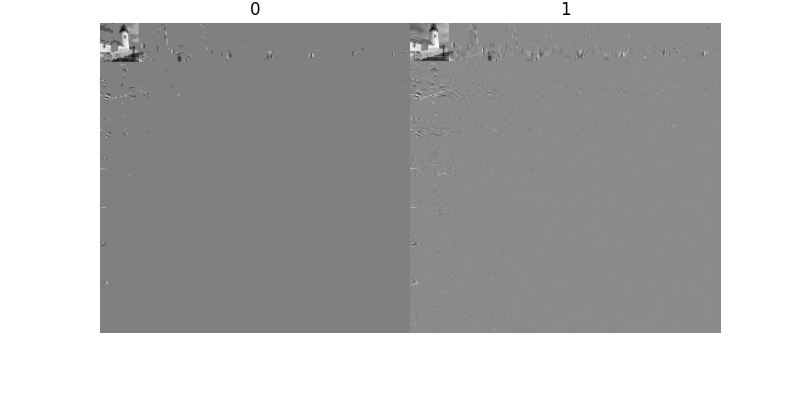

<IPython.core.display.Javascript object>


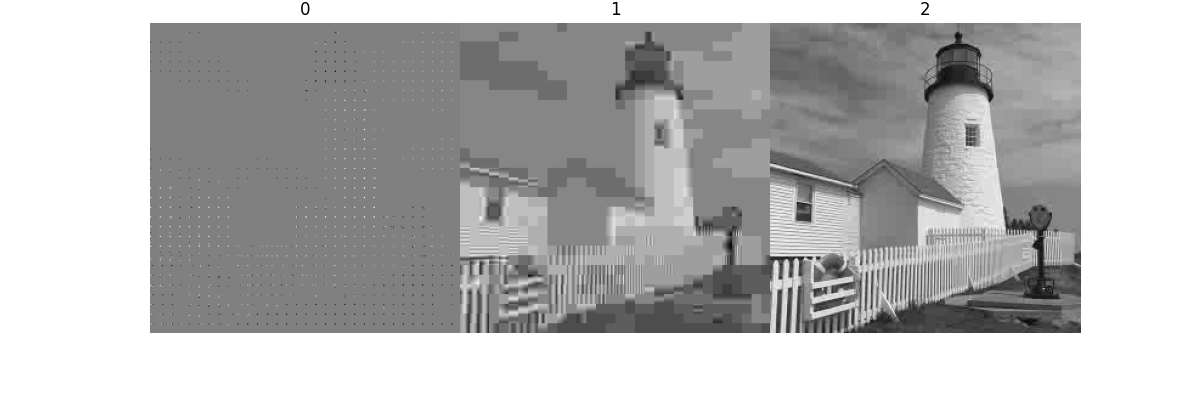

[1.4761390342259373, 5.112533649538287, 49.92237007203106, 6.762322590975161]


<IPython.core.display.Javascript object>


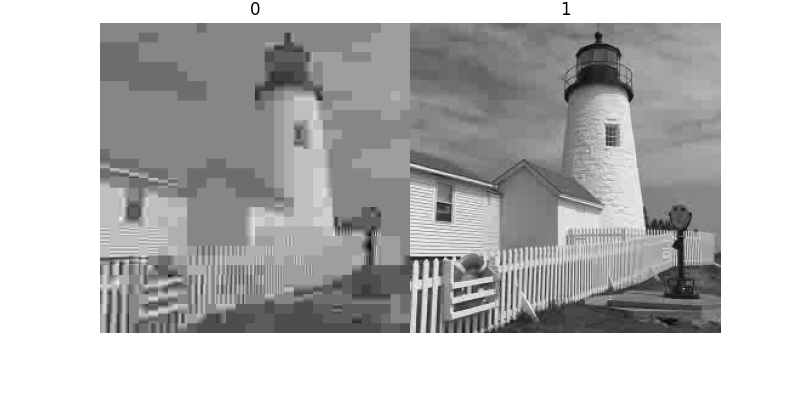

In [421]:
img = lighthouse
step = 23.691
ratio = 1.0
dct_check = dct_n_supp(img, 8, ratio*step, N = 16, fixedN = True, step = step)
print(dct_check[2:6])
plotImg(dct_check[6:8], cols = 2)

In [392]:
# calculate RMS error and tbit for a range of step sizes, for various values of ratio
ratio = 1.0
n_DCT_supp = 8 # DCT optimal = 8
step = 23.691 # DCT optimal step for n=8

# fixedN = True: image split into 16x16 sub-images to be compressed
dct_08 = dct_n_supp(lighthouse, n_DCT_supp, ratio*step, step=step, fixedN = True)

# tbit_DCT_supp = []
# tbit_DCT_nosupp = []
# rms_DCT_supp = []
# rms_DCT_nosupp = []
# comp_ratio_supp = []
# comp_ratio_nosupp = []
# Zn_supp = []
# Zn_nosupp = []

# tbit_DCT_supp.append(dct_08[0])
# tbit_DCT_nosupp.append(dct_08[1])
# rms_DCT_supp.append(dct_08[2])
# rms_DCT_nosupp.append(dct_08[3])
# comp_ratio_supp.append(dct_08[4])
# comp_ratio_nosupp.append(dct_08[5])
# Zn_supp.append(dct_08[6])
# Zn_nosupp.append(dct_08[7])

In [393]:
print("Original comp ratio:", dct_08[2], "\nSuppressed comp ratio:", dct_08[3])
print("improvement:", dct_08[3]/dct_08[2])

Original comp ratio: 5.144869948159338 
Suppressed comp ratio: 5.112533649538287
improvement: 0.9937148462552257


### LBT suppress

In [396]:
def lbt_n_supp(img, N, rise1, step=17, s=1.4, fixedN = False):
    img_q = quantise(img, 17)
    tbit_imgq = bpp(img_q)*img.shape[0]*img.shape[1]
    
    fLBT = forwardLBT(img, N, s)
    fLBTq = quantise(fLBT, step, rise1)
    
    fLBTq_supp = quantise(fLBT, step, rise1)
    fLBTq_supp[-256//n:, -256//n:] = quantise(fLBT[-256//n:, -256//n:], step, 100)
    
    fLBTr = regroup(fLBTq, N)/N
    fLBTr_supp = regroup(fLBTq_supp, N)/N
    
    rLBT = reverseLBT(fLBTq, N, s)
    rLBT_supp = reverseLBT(fLBTq_supp, N, s)
    
    rms_LBT = np.std(rLBT-img)
    rms_LBT_supp = np.std(rLBT_supp-img)
    
    if fixedN:
        tbit_lbt = dctbpp(fLBTr, 16)
        tbit_lbt_supp = dctbpp(fLBTr_supp, 16)
        
    else:
        tbit_lbt = dctbpp(fLBTr, N)
        tbit_lbt_supp = dctbpp(fLBTr_supp, N)
        
        
    comp_ratio = tbit_imgq/tbit_lbt
    comp_ratio_supp = tbit_imgq/tbit_lbt_supp
    
    return [tbit_lbt, tbit_lbt_supp, comp_ratio, comp_ratio_supp, rms_LBT, rLBT, fLBTq, fLBTr, fLBT]

In [399]:
# calculate RMS error and tbit for optimal stepsize and ratio
img = lighthouse
ratio = 0.5
n_LBT_supp = 8 # LBT optimal = 8
step = 25.885 # LBT optimal step for n=8
s = 1.4 # LBT optimal scaling factor

# fixedN = True: image split into 16x16 sub-images to be compressed
lbt_08 = lbt_n_supp(img, n_LBT_supp, rise1 = ratio*step, step=step, s=s, fixedN=True)

print("Original comp ratio:", lbt_08[2], "\nSuppressed comp ratio:", lbt_08[3])
print("improvement:", lbt_08[3]/lbt_08[2])

Original comp ratio: 3.4228310530085206 
Suppressed comp ratio: 3.521742100460403
improvement: 1.0288974377993163
